In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import warnings

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore') 

from src.SavingFeedback import SavingFeedback
from src import crs, PublicPredictor
from src.dbc import utils, TimeDivisionKMeans
import src.utils as ut

In [3]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)

# 3. data init
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)

month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)

calc = crs.models.ManagementOffice(
        month=_month,
        households=month_df,
        APT=APT,
        contract="단일계약"
    )
apt = calc.apart

# SavingFeedback Init

ECV : 47 %
이상패턴 조정 확인 True


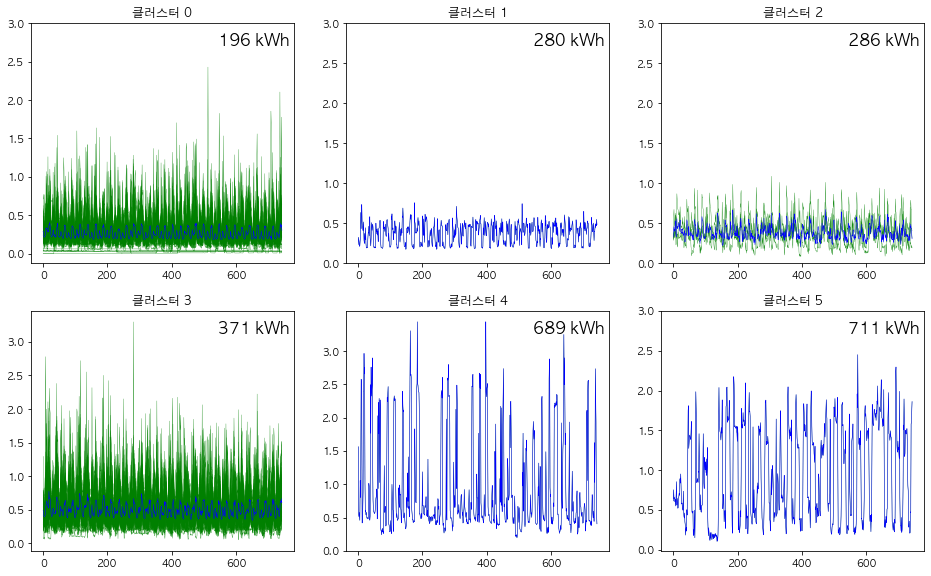

In [9]:
# 1. Data Pre-processing
sv = SavingFeedback(xlsx)
sv.select_month(1)

# 2. KMeans Run
sv.kmeans_run()

# 3. adjust anomaly
sv.adjust_anomaly()
anomaly = sv.check_anomaly()
print("이상패턴 조정 확인", len(anomaly) == 0)

sv.kmeans.draw_plot()

# Time Feedback

In [10]:
time_size = 4

sv.time_based_grouping(time_size)
sv.feedback()
sv.result()

time_group = sv.new_group.copy()
time_group.head()

round(time_group['usage (kWh)'].mean())

257

# Day Feedback

In [11]:
sv.day_based_grouping()
sv.feedback()
sv.result()

day_group = sv.new_group.copy()
day_group.head()

round(day_group['usage (kWh)'].mean())

264

# Compare
## Time

In [12]:
month = 1

before_month_df = sv.group[['name', 'usage (kWh)']].copy()
after_month_df = time_group[['name', 'usage (kWh)']].copy()
house_count = len(before_month_df)

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)
public_kWh = APT - before_month_df['usage (kWh)'].sum()
before_calc = crs.models.ManagementOffice(
        month=month,
        households=before_month_df,
        APT=APT,
        contract="단일계약"
    )

after_APT = after_month_df['usage (kWh)'].sum() + public_kWh
after_calc = crs.models.ManagementOffice(
        month=month,
        households=after_month_df,
        APT=after_APT,
        contract="단일계약"
    )

compare_df = pd.DataFrame()
compare_df.index = ['before', 'after']
compare_df['APT 평균 사용량'] = [before_calc.apart.kwh, after_calc.apart.kwh]
compare_df['세대부 평균 사용량'] = [round(before_month_df['usage (kWh)'].mean()),
                           round(after_month_df['usage (kWh)'].mean())]
compare_df['공용부 평균 사용량'] = [
    round(public_kWh / house_count),
    round(public_kWh / house_count)
]

compare_df['아파트 전체 요금'] = [
    before_calc.bill,
    after_calc.bill
]
compare_df['세대부 전체 요금'] = [
    before_calc.bill - before_calc.public_bill,
    after_calc.bill - after_calc.public_bill
]
compare_df['공용부 요금'] = [
    before_calc.public_bill,
    after_calc.public_bill
]

compare_df.loc['error'] = compare_df.loc['before'] - compare_df.loc['after']
compare_df

,APT 평균 사용량,세대부 평균 사용량,공용부 평균 사용량,아파트 전체 요금,세대부 전체 요금,공용부 요금
before,411,288,123,6439540,3798980,2640560
after,381,257,123,5225200,3096700,2128500
error,30,31,0,1214340,702280,512060


## Day

In [13]:
month = 1

before_month_df = sv.group[['name', 'usage (kWh)']].copy()
after_month_df = day_group[['name', 'usage (kWh)']].copy()
house_count = len(before_month_df)

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)
public_kWh = APT - before_month_df['usage (kWh)'].sum()
before_calc = crs.models.ManagementOffice(
        month=month,
        households=before_month_df,
        APT=APT,
        contract="단일계약"
    )

after_APT = after_month_df['usage (kWh)'].sum() + public_kWh
after_calc = crs.models.ManagementOffice(
        month=month,
        households=after_month_df,
        APT=after_APT,
        contract="단일계약"
    )

compare_df = pd.DataFrame()
compare_df.index = ['before', 'after']
compare_df['APT 평균 사용량'] = [before_calc.apart.kwh, after_calc.apart.kwh]
compare_df['세대부 평균 사용량'] = [round(before_month_df['usage (kWh)'].mean()),
                           round(after_month_df['usage (kWh)'].mean())]
compare_df['공용부 평균 사용량'] = [
    round(public_kWh / house_count),
    round(public_kWh / house_count)
]

compare_df['아파트 전체 요금'] = [
    before_calc.bill,
    after_calc.bill
]
compare_df['세대부 전체 요금'] = [
    before_calc.bill - before_calc.public_bill,
    after_calc.bill - after_calc.public_bill
]
compare_df['공용부 요금'] = [
    before_calc.public_bill,
    after_calc.public_bill
]

compare_df.loc['error'] = compare_df.loc['before'] - compare_df.loc['after']
compare_df

,APT 평균 사용량,세대부 평균 사용량,공용부 평균 사용량,아파트 전체 요금,세대부 전체 요금,공용부 요금
before,411,288,123,6439540,3798980,2640560
after,387,264,123,5331790,3222450,2109340
error,24,24,0,1107750,576530,531220


# Recovery Feedback Pattern

패턴 복구 완료


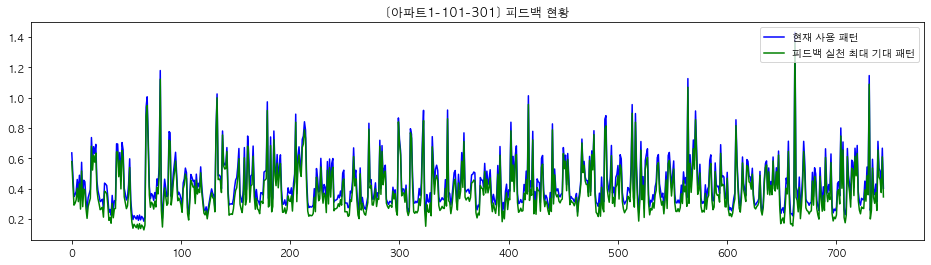

In [14]:
sv.recovery()

print("패턴 복구 완료")

ran_feedback = sv.group[sv.group['usage (kWh)'] != sv.new_group['usage (kWh)']].sample(n=1).copy()
name = ran_feedback['name'].values[0]
index = np.where(sv.datas.columns == name)[0][0]

plt.figure(figsize=(16,4))

plt.plot(sv.datas.values.T[index], label="현재 사용 패턴", color='b')
plt.plot(sv.recoveries[index], label="피드백 실천 최대 기대 패턴", color='g')
plt.title("[{}] 피드백 현황".format(name))

plt.legend(loc='upper right')
plt.show()

In [15]:
og_pat = sv.datas.values.T
rec_pat = sv.recoveries
err = (og_pat - rec_pat)
err[err != 0].min()

print(og_pat.shape, rec_pat.shape)
print("최소 오차", err[err != 0].min())

(108, 744) (108, 744)
최소 오차 0.0009999999999998899
